#Data Pre-processing


In [1]:
!wget -O images.tar http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget -O annotation.tar http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2020-11-16 21:29:57--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  4.24MB/s    in 2m 52s  

2020-11-16 21:32:49 (4.40 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-11-16 21:32:49--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  3.88MB/s    in 4.9s    

2020-11-16 21:32:54 (4.23 MB/s) - ‘annotat

In [2]:
!tar xf images.tar --totals
!tar xf annotation.tar --totals

Total bytes read: 793579520 (757MiB, 296MiB/s)
Total bytes read: 21852160 (21MiB, 16MiB/s)


In [3]:
import sys
import tensorflow as tf

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal
import torch
from torchvision import datasets, transforms

import numpy as np
from PIL import Image
import json
import os
import time
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import tarfile
import shutil
import glob
import pprint
import re
import xml.etree.ElementTree as ET

In [4]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [5]:
# run params
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

SEED_SIZE = 100

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SECTION = 'gan'
RUN_ID = '0004'
DATA_NAME = 'dogs'
DATA_PATH = RUN_ID

BATCH_SIZE = 32
BUFFER_SIZE = 60000
EPOCHS = 130
PRINT_EVERY_N_BATCHES = 5

mode =  'build' #'load' #

In [6]:
os.mkdir(DATA_PATH)

In [7]:
dir_input = "input"
path_img = os.path.join(dir_input, "images")
path_annot = os.path.join(dir_input, "annotations")

In [8]:
#shutil.rmtree(dir_input)
os.mkdir(dir_input)
os.mkdir(path_img)

In [9]:
img_filenames = glob.glob("Images/**/*.jpg", recursive=True)
print(len(img_filenames))

20580


In [10]:
#Copy all the images to the input directory
for name in tqdm(img_filenames):
  shutil.copy(name, path_img)
img_filenames = glob.glob("input/images/*.jpg", recursive=True)
print(img_filenames[1])

100%|██████████| 20580/20580 [00:03<00:00, 6632.13it/s]


input/images/n02091831_749.jpg


In [11]:
imgs = os.listdir(path_img)
print(len(imgs))
print(imgs[:5])

20580
['n02100236_304.jpg', 'n02091831_749.jpg', 'n02097474_8583.jpg', 'n02108422_3576.jpg', 'n02108000_3576.jpg']


In [12]:
#Copy all the annotations to the run directory
print("Copying all annotations into one big folder")
shutil.copytree("Annotation", path_annot)

Copying all annotations into one big folder


'input/annotations'

In [13]:
breeds = glob.glob(path_annot+'/*')
annotations = []
for breed in breeds:
    annotations += glob.glob(breed+'/*')
len(annotations)

20580

In [14]:
breed_map = {}
for annotation in annotations:
  breed = annotation.split('/')[-2]
  index = breed.split('-')[0]
  breed_map.setdefault(index,breed)
n_classes = len(breed_map)
n_classes

120

In [15]:
pprint.pprint(breed_map)

{'n02085620': 'n02085620-Chihuahua',
 'n02085782': 'n02085782-Japanese_spaniel',
 'n02085936': 'n02085936-Maltese_dog',
 'n02086079': 'n02086079-Pekinese',
 'n02086240': 'n02086240-Shih-Tzu',
 'n02086646': 'n02086646-Blenheim_spaniel',
 'n02086910': 'n02086910-papillon',
 'n02087046': 'n02087046-toy_terrier',
 'n02087394': 'n02087394-Rhodesian_ridgeback',
 'n02088094': 'n02088094-Afghan_hound',
 'n02088238': 'n02088238-basset',
 'n02088364': 'n02088364-beagle',
 'n02088466': 'n02088466-bloodhound',
 'n02088632': 'n02088632-bluetick',
 'n02089078': 'n02089078-black-and-tan_coonhound',
 'n02089867': 'n02089867-Walker_hound',
 'n02089973': 'n02089973-English_foxhound',
 'n02090379': 'n02090379-redbone',
 'n02090622': 'n02090622-borzoi',
 'n02090721': 'n02090721-Irish_wolfhound',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02091134': 'n02091134-whippet',
 'n02091244': 'n02091244-Ibizan_hound',
 'n02091467': 'n02091467-Norwegian_elkhound',
 'n02091635': 'n02091635-otterhound',
 'n020918

In [16]:
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def bounding_box(img):
    bpath = path_annot + str('/'+breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbxs = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbxs.append((xmin,ymin,xmax,ymax))
    return bbxs

In [17]:
def bounding_box_ratio(img):
    bpath = path_annot + str('/'+breed_map[img.split('_')[0]])+'/'+str(img.split('.')[0])
    tree  = ET.parse(bpath)
    root  = tree.getroot()
    objects = root.findall('object')
    bbx_ratios = []
    for o in objects:
        bndbox = o.find('bndbox') #reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        xlen = xmax - xmin
        ylen = ymax - ymin
        ratio = ylen / xlen
        bbx_ratios.append((xlen,ylen,ratio))
    return bbx_ratios

In [18]:
imgs_th = []
ratios_th = []
for img in tqdm(imgs):
  bbx_ratios = bounding_box_ratio(img)
  for i,(xlen,ylen,ratio) in enumerate(bbx_ratios):
      if ((ratio>0.2)&(ratio<4.0)):
          imgs_th.append(img[:-4]+'_'+str(i)+'.jpg')
          ratios_th.append(ratio)
ratios_th = np.array(ratios_th)

print('original : ', len(imgs))
print('after th : ', len(imgs_th))
pprint.pprint(imgs_th[:10])

100%|██████████| 20580/20580 [00:01<00:00, 19897.49it/s]

original :  20580
after th :  22120
['n02100236_304_0.jpg',
 'n02091831_749_0.jpg',
 'n02097474_8583_0.jpg',
 'n02108422_3576_0.jpg',
 'n02108000_3576_0.jpg',
 'n02086646_1952_0.jpg',
 'n02102973_23_0.jpg',
 'n02088094_7131_0.jpg',
 'n02088094_7131_1.jpg',
 'n02107142_6395_0.jpg']


In [19]:
#@title Intruders
intruders = [
  #n02088238-basset
  'n02088238_10870_0.jpg',
  
  #n02088466-bloodhound
  'n02088466_6901_1.jpg',
  'n02088466_6963_0.jpg',
  'n02088466_9167_0.jpg',
  'n02088466_9167_1.jpg',
  'n02088466_9167_2.jpg',
  
  #n02089867-Walker_hound
  'n02089867_2221_0.jpg',
  'n02089867_2227_1.jpg',
  
  #n02089973-English_foxhound # No details
  'n02089973_1132_3.jpg',
  'n02089973_1352_3.jpg',
  'n02089973_1458_1.jpg',
  'n02089973_1799_2.jpg',
  'n02089973_2791_3.jpg',
  'n02089973_4055_0.jpg',
  'n02089973_4185_1.jpg',
  'n02089973_4185_2.jpg',
  
  #n02090379-redbone
  'n02090379_4673_1.jpg',
  'n02090379_4875_1.jpg',
  
  #n02090622-borzoi # Confusing
  'n02090622_7705_1.jpg',
  'n02090622_9358_1.jpg',
  'n02090622_9883_1.jpg',
  
  #n02090721-Irish_wolfhound # very small
  'n02090721_209_1.jpg',
  'n02090721_1222_1.jpg',
  'n02090721_1534_1.jpg',
  'n02090721_1835_1.jpg',
  'n02090721_3999_1.jpg',
  'n02090721_4089_1.jpg',
  'n02090721_4276_2.jpg',
  
  #n02091032-Italian_greyhound
  'n02091032_722_1.jpg',
  'n02091032_745_1.jpg',
  'n02091032_1773_0.jpg',
  'n02091032_9592_0.jpg',
  
  #n02091134-whippet
  'n02091134_2349_1.jpg',
  'n02091134_14246_2.jpg',
  
  #n02091244-Ibizan_hound
  'n02091244_583_1.jpg',
  'n02091244_2407_0.jpg',
  'n02091244_3438_1.jpg',
  'n02091244_5639_1.jpg',
  'n02091244_5639_2.jpg',
  
  #n02091467-Norwegian_elkhound
  'n02091467_473_0.jpg',
  'n02091467_4386_1.jpg',
  'n02091467_4427_1.jpg',
  'n02091467_4558_1.jpg',
  'n02091467_4560_1.jpg',
  
  #n02091635-otterhound
  'n02091635_1192_1.jpg',
  'n02091635_4422_0.jpg',
  
  #n02091831-Saluki
  'n02091831_1594_1.jpg',
  'n02091831_2880_0.jpg',
  'n02091831_7237_1.jpg',
  
  #n02092002-Scottish_deerhound
  'n02092002_1551_1.jpg',
  'n02092002_1937_1.jpg',
  'n02092002_4218_0.jpg',
  'n02092002_4596_0.jpg',
  'n02092002_5246_1.jpg',
  'n02092002_6518_0.jpg',
  
  #n02093256-Staffordshire_bullterrier
  'n02093256_1826_1.jpg',
  'n02093256_4997_0.jpg',
  'n02093256_14914_0.jpg',
  
  #n02093428-American_Staffordshire_terrier
  'n02093428_5662_0.jpg',
  'n02093428_6949_1.jpg'
]


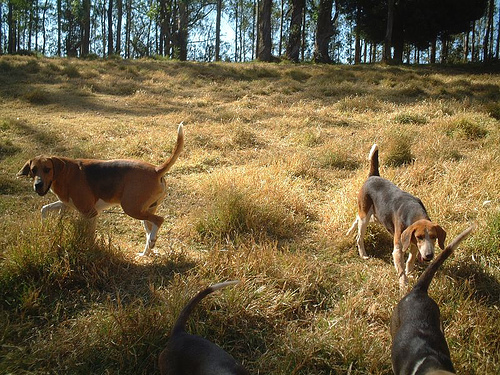

In [20]:
ind = imgs.index('n02089973_1132.jpg')
Image.open(path_img+'/'+imgs[ind])

In [21]:
def autocontrast(img, cutoff=1): #cutoff[%]
    if np.random.rand() < 0.5:
        img = ImageOps.autocontrast(img, cutoff)
    return img

def sharpen(img, magnitude=1):
    factor = np.random.uniform(1.0-magnitude, 1.0+magnitude)
    img    = ImageEnhance.Sharpness(img).enhance(factor)
    return img
    
def data_preprocessing(img,bbx_idx):
    bbx = bounding_box(img)[bbx_idx]
    img  = Image.open(os.path.join(path_img, img)).convert('RGB')
    img_cropped  = img.crop(bbx)
    return img_cropped

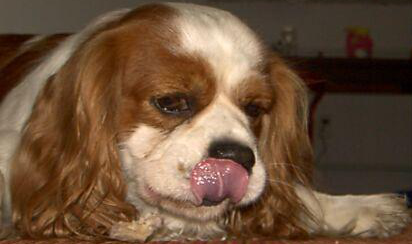

In [22]:
#imgindex = img_filenames.index('Images/n02091831-saluki')
img = data_preprocessing(imgs_th[112][:-6]+'.jpg',0)
img

In [23]:
breed_map_2 = {}
for i,b in enumerate(breed_map.keys()):
    breed_map_2[b] = i

In [24]:
transformations = transforms.Compose([transforms.Resize(GENERATE_SQUARE),
                                      transforms.RandomCrop(GENERATE_SQUARE),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                      ])
training_data = []
labels = []
for img in tqdm(imgs_th):
  if img in intruders:
    continue
  img_location = img[:-6]+'.jpg'
  bbx_idx = int(img[-5])
  img = data_preprocessing(img_location, bbx_idx)
  img = tf.make_tensor_proto(transformations(img))
  img = tf.make_ndarray(img)
  training_data.append(img)
  label = breed_map_2[img_location.split('_')[0]]
  labels.append(label)
print(len(training_data))

100%|██████████| 22120/22120 [01:29<00:00, 246.91it/s]

22060


In [25]:
print(training_data[1])

[[[-0.8509804  -0.8039216  -0.78039217 ...  0.8117647   0.8509804
    0.81960785]
  [-0.8352941  -0.827451   -0.8039216  ...  0.7882353   0.827451
    0.7411765 ]
  [-0.78039217 -0.7882353  -0.8039216  ...  0.48235297  0.5137255
    0.36470592]
  ...
  [-0.6392157  -0.5686275  -0.47450978 ... -0.5372549  -0.45098037
   -0.41176468]
  [-0.7490196  -0.654902   -0.5764706  ... -0.47450978 -0.372549
   -0.26274508]
  [-0.70980394 -0.73333335 -0.6392157  ... -0.38039213 -0.27843136
   -0.20784312]]

 [[-0.8745098  -0.827451   -0.79607844 ...  0.7411765   0.77254903
    0.77254903]
  [-0.84313726 -0.8352941  -0.8039216  ...  0.7254902   0.7411765
    0.67058825]
  [-0.79607844 -0.7882353  -0.8117647  ...  0.3803922   0.38823533
    0.254902  ]
  ...
  [-0.6156863  -0.5529412  -0.4588235  ... -0.7254902  -0.6627451
   -0.62352943]
  [-0.7490196  -0.6392157  -0.56078434 ... -0.67058825 -0.5921569
   -0.47450978]
  [-0.75686276 -0.7176471  -0.6        ... -0.5686275  -0.4823529
   -0.41176468]]

In [26]:
training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)

In [27]:
print(training_data[1].shape)

(64, 64, 3)


In [28]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Model

In [29]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [30]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

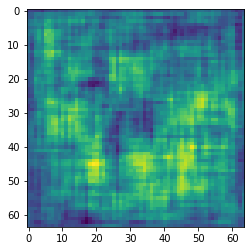

In [31]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [32]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.499391]], shape=(1, 1), dtype=float32)


In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,0.9,0.99)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,0.9,0.99)

In [35]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [36]:
g_loss_epochs = []
d_loss_epochs = []

In [37]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    g_loss_epochs.append(g_loss)
    d_loss_epochs.append(d_loss)
    
    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = hms_string(time.time()-start)

  print ('Training time: '+ elapsed)


In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6692396998405457,disc loss=1.1216987371444702, 0:00:44.70
Epoch 2, gen loss=0.6931458115577698,disc loss=1.0064088106155396, 0:00:41.94
Epoch 3, gen loss=0.6931456923484802,disc loss=1.006408929824829, 0:00:43.02
Epoch 4, gen loss=0.6931458711624146,disc loss=1.0064088106155396, 0:00:43.55
Epoch 5, gen loss=0.6914581060409546,disc loss=1.0153563022613525, 0:00:43.38
Epoch 6, gen loss=0.6931458711624146,disc loss=1.0064088106155396, 0:00:43.45
Epoch 7, gen loss=0.6931458711624146,disc loss=1.0064088106155396, 0:00:43.36
Epoch 8, gen loss=0.6901823282241821,disc loss=1.0157533884048462, 0:00:43.26
Epoch 9, gen loss=0.6928475499153137,disc loss=1.007339596748352, 0:00:43.25
Epoch 10, gen loss=0.6873833537101746,disc loss=1.0204768180847168, 0:00:43.30
Epoch 11, gen loss=0.6926616430282593,disc loss=1.009498119354248, 0:00:43.18
Epoch 12, gen loss=0.6931458711624146,disc loss=1.0064091682434082, 0:00:42.76
Epoch 13, gen loss=0.6931458711624146,disc loss=1.00640881061553

In [ ]:
plt.plot(d_loss_epochs, label='D_loss')
plt.plot(g_loss_epochs, label='G_loss')
plt.grid()
plt.legend()
plt.title('loss history');
plt.savefig(os.path.join(DATA_PATH,"loss_history.png"))
plt.show()

In [ ]:
generator.save(os.path.join(DATA_PATH,"dog_generator.h5"))

In [ ]:
!zip -r {DATA_PATH}\.zip {DATA_PATH}

In [ ]:
from google.colab import files
files.download(DATA_PATH+".zip")